# EAE vs external spleen

In [1]:
# this script do dimension reduce first, then transform new data with the same reducer

In [2]:
import warnings
warnings.filterwarnings("ignore")
import muon as mu
import numpy as np
import scanpy as sc
import scirpy as ir
import pandas as pd
from cycler import cycler
from matplotlib import cm as mpl_cm
from matplotlib import pyplot as plt
from mudata import MuData
sc.set_figure_params(figsize=(4, 4))
sc.settings.verbosity = 2  # verbosity: errors (0), warnings (1), info (2), hints (3)

### load EAE data

In [3]:
%cd /ihome/ylee/yiz133/Code/Scirpy/scripy/data

/ihome/ylee/yiz133/Code/Scirpy/scripy/data


In [4]:
## read raw data
# adata_gex = sc.read("all_gex.h5ad")
# adata_gex.var_names

In [5]:
mdata = mu.read("0605_mData_allCommon.h5mu")
mdata

MuData object with n_obs × n_vars = 77660 × 33708
  obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'percent.mt', 'integrated_nn_res.2', 'seurat_clusters', 'level_2_clusters', 'manual_cell_type', 'run_num', 'sample'
  2 modalities
    gex:	77660 x 33708
      obs:	'mouse_id', 'date', 'tissue', 'sample'
    airr:	77660 x 0
      obsm:	'airr'

In [6]:
mdata['gex'].obs['manual_cell_type'] = mdata.obs['manual_cell_type']
adata_gex = mdata['gex']

adata_gex = adata_gex[adata_gex.obs["date"].isin(["0605"])]
# adata_gex = adata_gex[adata_gex.obs["manual_cell_type"].isin(["CD4+ T"])]

adata_CNS = adata_gex[adata_gex.obs['tissue'].isin(["CN"])]
adata_SPL = adata_gex[adata_gex.obs['tissue'].isin(["SP"])]

adata_gex.obs['tissue']

AAACCAAAGATGCCCG-1_0605_CNS    CN
AAACCAAAGCGTTGAC-1_0605_CNS    CN
AAACCAAAGCTAGTGC-1_0605_CNS    CN
AAACCAAAGCTCGAGT-1_0605_CNS    CN
AAACCAAAGGTCCTAA-1_0605_CNS    CN
                               ..
GTTGTGGGTGGAGCGA-1_0605_SPL    SP
GTTGTGGGTGGATCGC-1_0605_SPL    SP
GTTGTGGGTGGCTGTA-1_0605_SPL    SP
GTTGTGGGTGTCCCTG-1_0605_SPL    SP
GTTGTGGGTGTTACCC-1_0605_SPL    SP
Name: tissue, Length: 46686, dtype: category
Categories (2, object): ['CN', 'SP']

In [7]:
adata_gex.var_names_make_unique()

adata_gex.var["mt"] = adata_gex.var_names.str.startswith("mt-")
# ribosomal genes
adata_gex.var["ribo"] = adata_gex.var_names.str.startswith(("Rps", "Rpl"))
# hemoglobin genes
adata_gex.var["hb"] = adata_gex.var_names.str.contains("^Hb[^(p)]")

sc.pp.calculate_qc_metrics(
    adata_gex, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

In [8]:
# adata = adata_gex
sc.pp.filter_cells(adata_gex, min_genes= 200)
sc.pp.filter_cells(adata_gex, max_genes= 8000)

sc.pp.filter_cells(adata_gex, min_counts= 100)
sc.pp.filter_cells(adata_gex, max_counts= 30000)

sc.pp.filter_genes(adata_gex, min_cells= 10)
# sc.pp.filter_genes(adata, max_cells=100)

# sc.pp.filter_genes(adata, min_counts=50)
# sc.pp.filter_genes(adata, max_counts=100)

filtered out 1 cells that have less than 200 genes expressed
filtered out 1 cells that have more than 8000 genes expressed
filtered out 370 cells that have more than 30000 counts
filtered out 14061 genes that are detected in less than 10 cells


In [9]:
# remove mt- genes
adata_gex = adata_gex[:, ~adata_gex.var_names.str.startswith(('mt', 'CMO'))].copy()

# normalize
sc.pp.normalize_total(adata_gex)
sc.pp.log1p(adata_gex)

sc.pp.highly_variable_genes(adata_gex, n_top_genes=2000)
adata_gex = adata_gex[:, adata_gex.var['highly_variable']].copy()
adata_gex

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:01)


AnnData object with n_obs × n_vars = 46314 × 2000
    obs: 'mouse_id', 'date', 'tissue', 'sample', 'manual_cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'n_counts'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

## clusters

In [19]:
adata_combine = adata_gex
adata_combine.obs['tissue'].value_counts()

tissue
SP           31550
CN           14764
SPL_ext_2     8806
SPL_ext_1     7458
Name: count, dtype: int64

In [20]:
sc.pp.pca(adata_combine, svd_solver="arpack", n_comps=20)

computing PCA
    with n_comps=20
    finished (0:00:07)


computing neighbors
    using 'X_pca' with n_pcs = 20
    finished (0:00:39)
computing UMAP
    finished (0:01:30)
running Leiden clustering
    finished (0:00:04)


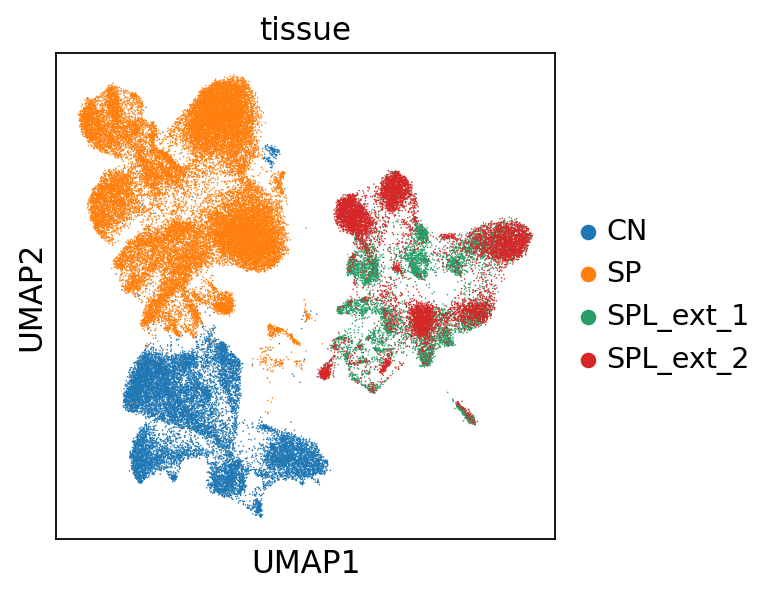

In [21]:
sc.pp.neighbors(adata_combine, n_neighbors = 20)
sc.tl.umap(adata_combine, min_dist=0.5, spread=1.0)
sc.tl.leiden(adata_combine, resolution = 0.5, n_iterations=2, flavor = 'igraph')
sc.pl.umap(adata_combine, color=["tissue"])

In [22]:
# DO Batch correction

# sc.external.pp.harmony_integrate(adata_combine, "tissue")

# sc.pp.neighbors(adata_combine, use_rep='X_pca_harmony')

2025-06-27 11:20:34,026 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f6f6b638d60>
Traceback (most recent call last):
  File "/ihome/crc/install/python/ondemand-jupyter-python3.11-2023.09/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/ihome/crc/install/python/ondemand-jupyter-python3.11-2023.09/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/ihome/crc/install/python/ondemand-jupyter-python3.11-2023.09/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  

computing neighbors
    finished (0:00:09)


computing UMAP
    finished (0:01:20)


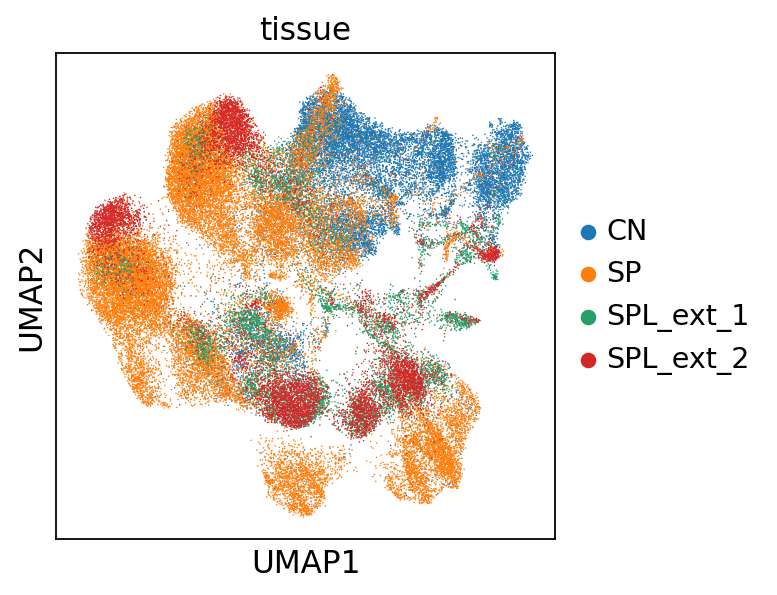

In [23]:
sc.tl.umap(adata_combine)
sc.pl.umap(adata_combine, color=["tissue"])

## PCA on the training set

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
train_idx = adata_combine.obs['tissue'].isin(["CN","SP"])
adata_train = adata_combine[train_idx]
adata_test = adata_combine[~train_idx]

In [26]:
adata_train

View of AnnData object with n_obs × n_vars = 46314 × 2000
    obs: 'mouse_id', 'date', 'tissue', 'sample', 'manual_cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'n_counts', 'leiden'
    uns: 'pca', 'neighbors', 'umap', 'leiden', 'tissue_colors'
    obsm: 'X_pca', 'X_umap', 'X_pca_harmony'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [27]:
adata_test

View of AnnData object with n_obs × n_vars = 16264 × 2000
    obs: 'mouse_id', 'date', 'tissue', 'sample', 'manual_cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'n_counts', 'leiden'
    uns: 'pca', 'neighbors', 'umap', 'leiden', 'tissue_colors'
    obsm: 'X_pca', 'X_umap', 'X_pca_harmony'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [28]:
# external_spl, 
DF_train = adata_train.to_df()
DF_all = adata_combine.to_df()

In [ ]:
### add other adata.obs to the DF

In [45]:
obs_to_include = ['manual_cell_type']
for obs in obs_to_include:
    DF_train[obs] = adata_train.obs[obs].astype('category').cat.codes
    

In [29]:
%cd "/ihome/ylee/yiz133/Code/Data processing/"

/ihome/ylee/yiz133/Code/Data processing


In [46]:
# Initialize StandardScaler
import pandas as pd

scaler = StandardScaler()
# scaler =  MinMaxScaler()

# # Fit and transform the data
# # X_scaled will be a NumPy array
# X_scaled_train = scaler.fit_transform(DF_train)
# X_scaled_all = scaler.transform(DF_all)

X_scaled_train = DF_train
X_scaled_all = DF_all

In [48]:
pca = PCA(n_components=50, svd_solver='randomized', random_state=42)
pca.fit(X_scaled_train)

X_pca_train = pca.transform(X_scaled_train)

X_pca_all = pca.transform(X_scaled_all)

# Convert the transformed data to a DataFrame for easier handling
df_pca_all = pd.DataFrame(data=X_pca_all)
df_pca_all.index = DF_all.index

In [54]:
DF_classes = adata_train.obs
DF_classes.index = DF_train.index
DF_classes.head(3)

,mouse_id,date,tissue,sample,manual_cell_type,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,...,pct_counts_mt,total_counts_ribo,log1p_total_counts_ribo,pct_counts_ribo,total_counts_hb,log1p_total_counts_hb,pct_counts_hb,n_genes,n_counts,leiden
AAACCAAAGATGCCCG-1_0605_CNS,CMO317,0605,CN,CNS_0605,Treg,2085.0,7.643004,5263.0,8.568646,25.897777,...,1.501045,1172.0,7.067320,22.268667,0.0,0.0,0.0,2085.0,5263.0,0
AAACCAAAGCGTTGAC-1_0605_CNS,CMO318,0605,CN,CNS_0605,CD4+ T,4603.0,8.434681,19431.0,9.874677,25.515928,...,1.672585,4674.0,8.449985,24.054346,0.0,0.0,0.0,4603.0,19431.0,2
AAACCAAAGCTAGTGC-1_0605_CNS,CMO326,0605,CN,CNS_0605,multiplet,1886.0,7.542744,5538.0,8.619569,38.118454,...,1.841820,1645.0,7.406104,29.703865,0.0,0.0,0.0,1886.0,5538.0,4


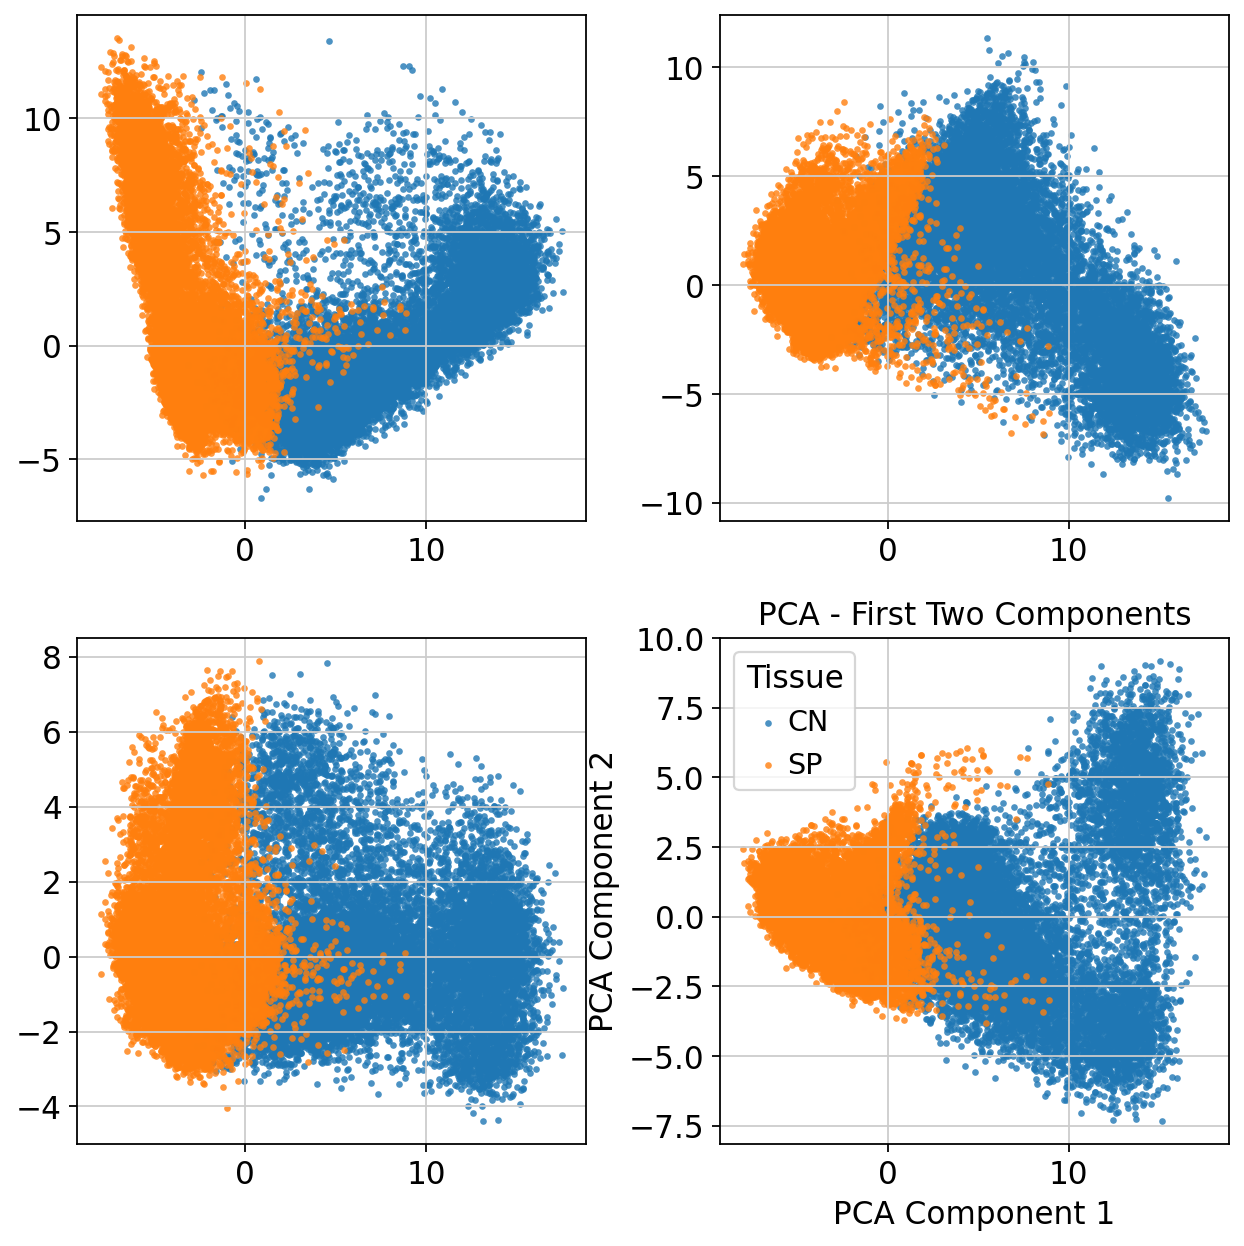

In [64]:
fig, ax = plt.subplots(2,2, figsize=(8, 8))

y = DF_classes['tissue'].unique()
pca_num = 4

for i in range(pca_num):
    for category in y:
        X_pca_sub = X_pca_train[DF_classes['tissue'] == category]

        ax[int(i/2), i%2].scatter(
            X_pca_sub[:,0], X_pca_sub[:, i+1],
            label=category,
            alpha=0.8,
            linewidths=0.0001,
            marker='.'
        )
    
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA - First Two Components")
plt.legend(title="Tissue")  # Add legend with title
plt.grid(True)
plt.tight_layout()
plt.show()

### umap

In [ ]:
import umap

umap = umap.UMAP(n_components=2, n_neighbors=20, min_dist=0.5, spread = 2)
X_umap_all = umap.fit_transform(df_pca_all)

# Convert the transformed data to a DataFrame for easier handling
df_umap_all = pd.DataFrame(data=X_umap_all)

df_umap_all.index = DF_all.index

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(12,12))
i = 0

for category in y:
    X_pca_sub = df_umap_all[DF_classes['tissue'] == category]
    
    ax[int(i/2), i%2].scatter(
        X_pca_sub.iloc[:,0], X_pca_sub.iloc[:, 1],
        label=category,
        alpha=0.8,
        linewidths=0.0001,
        marker='.'
    )
    i += 1

for category in y:
    X_pca_sub = df_umap_all[DF_classes['tissue'] == category]
    ax[1,1].scatter(
        X_pca_sub.iloc[:,0], X_pca_sub.iloc[:, 1],
        label=category,
        alpha=0.8,
        linewidths=0.0001,
        marker='.'
    )
        
plt.title("UMAP")
plt.legend(title ='tissue')
plt.show(block=False)

In [ ]:
%cd "/ihome/ylee/yiz133/Code/Data processing/"

In [ ]:
df_pca_all.to_csv('features_PCA50.csv')
DF_classes.to_csv('obs_classes.csv')
# df_umap_all.to_csv('features_Umap2.csv')


In [ ]:
aaa

## load multiple .mtx sets

In [ ]:
# Reindex anndata2 to match anndata1 genes (fill missing genes with zeros)
import anndata as ad
def merge_anndata_to_base(anndata1, anndata2):
    c_gene = anndata2.var_names.intersection(anndata1.var_names)

    missing_genes = anndata1.var_names.difference(anndata2.var_names)

    # Pad missing genes with zeros (assumes dense arrays, can be adapted for sparse)
    if len(missing_genes) > 0:
        import pandas as pd
        import scipy.sparse

        shape = (anndata2.n_obs, len(missing_genes))
        X_pad = np.zeros(shape, dtype=anndata2.X.dtype)
        X_pad = scipy.sparse.csr_matrix(X_pad) if isinstance(anndata2.X, scipy.sparse.spmatrix) else X_pad

        # Create dummy .var for missing genes
        var_pad = pd.DataFrame(index=missing_genes)

        # Create a temporary AnnData with padded genes
        adata_pad = ad.AnnData(X=X_pad, obs=anndata2.obs.copy(), var=var_pad)

        # Add missing genes and reorder to match anndata1
        anndata2_full = ad.concat([anndata2, adata_pad], axis=1)
        anndata2_full = anndata2_full[:, anndata1.var_names]

    else:
        anndata2_full = anndata2[:, anndata1.var_names]
    return anndata2_full

In [ ]:
path = ["/ihome/ylee/yiz133/Code/Data processing/data/External/Spleen GSE256414/1/",
       "/ihome/ylee/yiz133/Code/Data processing/data/External/Spleen GSE256414/2/",
       "/ihome/ylee/yiz133/Code/Data processing/data/External/Brain GSE250578/1/",
        "/ihome/ylee/yiz133/Code/Data processing/data/External/CNS SPL GSE156718/",
        "/ihome/ylee/yiz133/Code/Data processing/data/External/CNS GSE216390/GSM6671889/",
       ]

file_prefix = ["GSM8098198_Aged-CTRL-1-3_S3.",
              "GSM8098204_Young-CTRL-1-1_S1.",
              "GSM7981918_KO_UMI_",
               "GSE156718_GEX-HTO_5_iLN_",
               "",
              ]

tissues = ['SPL_ext_1', 'SPL_ext_2', 'CNS_ext_1', 'EAE_ext', "CNS_ext_2"]

In [ ]:
# for i in range(len(path)):
gene_sets = {}
for i in [0,1]:    
    adata_ext = sc.read_10x_mtx(path[i], var_names='gene_symbols', 
                              make_unique=True, cache=False, gex_only=True,
                              prefix = file_prefix[i])
    print(adata_ext)
    
    adata_ext.var_names_make_unique()
    sc.pp.normalize_total(adata_ext)
    sc.pp.log1p(adata_ext)
    adata_ext = adata_ext[:, ~adata_ext.var_names.str.startswith('mt')].copy()
    
    # adata = adata_gex
    # sc.pp.filter_cells(adata_ext, min_genes= 10)
    # sc.pp.filter_cells(adata_ext, max_genes= 8000)
    # sc.pp.filter_cells(adata_ext, min_counts=100)
    # sc.pp.filter_cells(adata_ext, max_counts=30000)
    # sc.pp.filter_genes(adata_ext, min_cells= 10)

    gene_sets[f'adata_ext_{i}'] = merge_anndata_to_base(adata_gex, adata_ext)
    
    gene_sets[f'adata_ext_{i}'].obs['tissue'] = tissues[i]

In [ ]:
adata_gex.var_names.intersection(adata_ext.var_names)

In [ ]:
!pwd

### Merge with EAE data

In [ ]:
all_adatas = {"main": adata_gex, **gene_sets}

In [ ]:
# only training data
# adata_combine = adata_gex

# training and test dict
adata_combine = ad.concat(all_adatas, join="outer")
adata_combine

In [ ]:
# adata_combine = ad.concat([adata_gex, gene_sets['adata_ext_0'], gene_sets['adata_ext_1'], 
#                           gene_sets['adata_ext_2'] ], join="outer")

# adata_combine = ad.concat([adata_gex, gene_sets['adata_ext_3']], join="outer")

In [ ]:
# Concatenate along observations
# adata_combine = ad.concat([anndata1, anndata2_full], axis=0 , join="inner")
# adata_combine.obs['tissue'].value_counts()
# adata_combine

## load Spleen GSE134157

In [ ]:
### only external data set can be predicted

In [ ]:
%cd "/ihome/ylee/yiz133/Code/Data processing/data/External/Spleen GSE134157 one set"

In [ ]:
import pandas as pd
EAE_feature = pd.read_csv('EAE_features.tsv', sep='\t', header=None, usecols=[0, 1])
data_dict = dict(zip(EAE_feature[0], EAE_feature[1]))
# data_dict

In [ ]:
external_spl = pd.read_csv('GSE134157_UMImatrix_NICD_protector.tsv', sep='\t', header=0)
external_spl = external_spl.set_index('Unnamed: 0')
external_spl = external_spl.T
external_spl.head(5)

### change gene id to names

In [ ]:
external_spl.columns = external_spl.columns.to_series().map(
    lambda x: data_dict.get(x,x)
)
external_spl.head(5)

In [ ]:
ans = external_spl.columns.to_series().str.startswith('ENSMUSG')
ans.value_counts()

In [ ]:
external_spl.columns.intersection(adata_SPL.var_names)

In [ ]:
import anndata as ad
adata_ext = ad.AnnData(X=external_spl)
# obs=pd.DataFrame(external_spl.index), var=pd.DataFrame(external_spl.columns)
adata_ext = adata_ext[:-2]

In [ ]:
adata_ext.obs['tissue'] = 'SPL_ext'
adata_ext.obs['tissue'] = adata_ext.obs['tissue'].astype('category')
adata_ext.obs['tissue']

In [ ]:
adata_combine = ad.concat((adata_gex,adata_ext), join="outer")

# end

In [ ]:
%pwd

In [ ]:
pca.fit(X_scaled_train)

X_pca_train = pca.transform(X_scaled_train)

# Convert the transformed data to a DataFrame for easier handling
df_pca_2 = pd.DataFrame(data=X_pca_train)
df_pca_2.index = DF_train.index
df_pca_2.to_csv('features_PCA50_train.csv')
